# GHP Construction with Duration Matching

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import edhec_risk_kit as erk
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
erk.bond_cash_flows(maturity=3, principal=100, coupon_rate=0.03, coupons_per_year=2)

1      1.5
2      1.5
3      1.5
4      1.5
5      1.5
6    101.5
dtype: float64

In [8]:
erk.bond_price(maturity=20, principal=1000, coupon_rate=0.05, coupons_per_year=2, discount_rate=0.04)

1136.7773962036904

In [9]:
erk.bond_price(maturity=20, principal=1000, coupon_rate=0.05, coupons_per_year=2, discount_rate=0.05)

1000.0000000000023

In [10]:
erk.bond_price(maturity=20, principal=1000, coupon_rate=0.05, coupons_per_year=2, discount_rate=0.02)

1492.520291709342

In [11]:
rates = np.linspace(0.01, 0.10, num=20)
rates

array([0.01      , 0.01473684, 0.01947368, 0.02421053, 0.02894737,
       0.03368421, 0.03842105, 0.04315789, 0.04789474, 0.05263158,
       0.05736842, 0.06210526, 0.06684211, 0.07157895, 0.07631579,
       0.08105263, 0.08578947, 0.09052632, 0.09526316, 0.1       ])

In [13]:
prices = [erk.bond_price(maturity=10, principal=1000, coupon_rate=0.05, coupons_per_year=2, discount_rate=rate) for rate in rates]
prices

[1379.7483829333992,
 1326.7629283179222,
 1276.1632981372743,
 1227.833537616068,
 1181.6636507727876,
 1137.5492793724407,
 1095.3913999300185,
 1055.0960377089511,
 1016.5739967228162,
 979.7406048086303,
 944.5154728963505,
 910.8222676519945,
 878.5884967212596,
 847.74530584692,
 818.2272871767957,
 789.9722981198867,
 762.9212901465673,
 737.0181469646424,
 712.209531536784,
 688.4447414365]

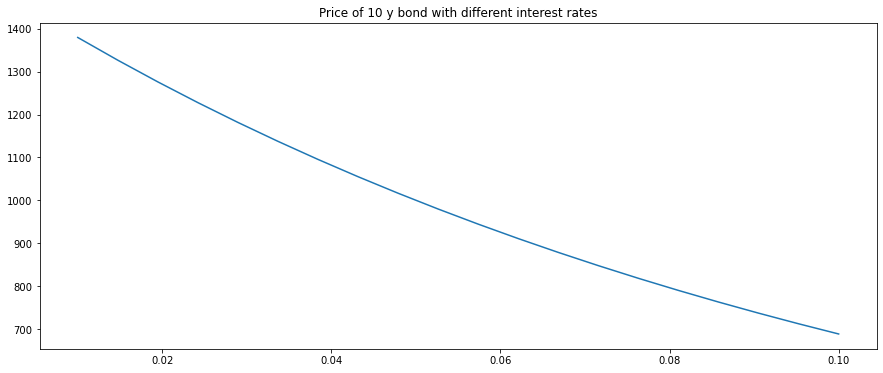

In [16]:
pd.DataFrame(data=prices, index=rates).plot(title='Price of 10 y bond with different interest rates', legend=False, figsize=(15,6))

In [18]:
cf = erk.bond_cash_flows(3, 1000, 0.06, 2)
cf

1      30.0
2      30.0
3      30.0
4      30.0
5      30.0
6    1030.0
dtype: float64

In [19]:
discounts = erk.discount(cf.index, 0.06/2)
discounts

Float64Index([ 0.970873786407767, 0.9425959091337544, 0.9151416593531595,
              0.8884870479156888, 0.8626087843841639, 0.8374842566836542],
             dtype='float64')

In [21]:
dcf = discounts * cf
dcf

1     29.126214
2     28.277877
3     27.454250
4     26.654611
5     25.878264
6    862.608784
dtype: float64

In [24]:
weights = dcf/dcf.sum()
weights

1    0.029126
2    0.028278
3    0.027454
4    0.026655
5    0.025878
6    0.862609
dtype: float64

In [27]:
(cf.index * weights).sum()

5.579707187194534

In [29]:
erk.macaulay_duration(cf, 0.06/2)

5.579707187194534

In [30]:
erk.macaulay_duration(erk.bond_cash_flows(3, 1000, 0.06, 2), 0.06/2)

5.579707187194534

## Duration Matching

In [35]:
liabilities = pd.Series(data=[100_000, 100_000], index=[10, 12])
erk.macaulay_duration(liabilities, 0.04)

10.960799385088393

In [38]:
md_10 = erk.macaulay_duration(erk.bond_cash_flows(10, 1000, 0.05, 1), 0.04)
md_20 = erk.macaulay_duration(erk.bond_cash_flows(20, 1000, 0.05, 1), 0.04)

md_10, md_20

(8.190898824083233, 13.544718122145921)

In our case, the fraction in the short duration asset $w_s$ should be such that:

$$ w_s \times 8.19 + (1-w_s) \times 13.54 = 10.96 $$

more generally:

$$ w_s \times d_s + (1-w_s) \times d_l = d_t $$

rearranging gives:

$$ w_s = \frac{d_l - d_t}{d_l - d_s} $$

In [42]:
short_bond = erk.bond_cash_flows(10, 1000, 0.05, 1)
long_bond = erk.bond_cash_flows(20, 1000, 0.05, 1)

w_s = erk.match_durations(liabilities, short_bond, long_bond, 0.04)
w_s, 1-w_s

(0.48263092069478974, 0.5173690793052103)

In [43]:
p_short = erk.bond_price(10, 1000, 0.05, 1, 0.04)
p_long = erk.bond_price(20, 1000, 0.05, 1, 0.04)
a_0 = 130_000
p_flows = pd.concat([a_0*w_s*short_bond/p_short, a_0*(1-w_s)*long_bond/p_long])
erk.macaulay_duration(p_flows, 0.04)

10.960799385088393

In [35]:
liabilities = pd.Series(data=[100_000, 100_000], index=[10, 12])
erk.macaulay_duration(liabilities, 0.04)

10.960799385088393

In [46]:
cfr = erk.funding_ratio(p_flows, liabilities, 0.04)
cfr

0.9998760012192478

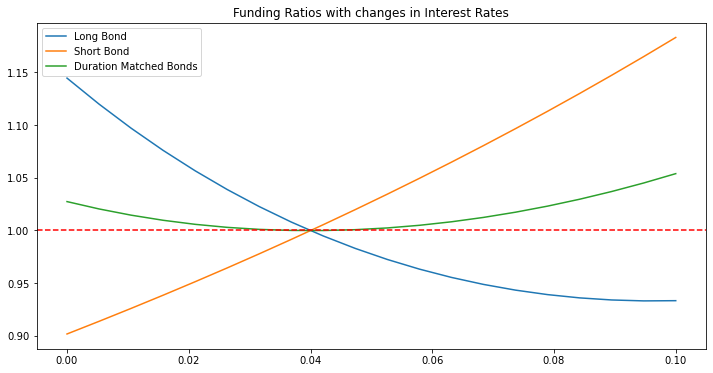

In [53]:
rates = np.linspace(0, 0.1, 20)
lb_assets = a_0*long_bond/p_long
sb_assets = a_0*short_bond/p_short

fr_change = pd.DataFrame({
    'Long Bond': [erk.funding_ratio(lb_assets, liabilities, r) for r in rates],
    'Short Bond': [erk.funding_ratio(sb_assets, liabilities, r) for r in rates],
    'Duration Matched Bonds': [erk.funding_ratio(p_flows, liabilities, r) for r in rates]
}, index=rates)

ax = fr_change.plot(title='Funding Ratios with changes in Interest Rates', figsize=(12,6))
ax.axhline(y=1.0, color='red', ls='--')